# Comparison of Machine Learning methods to classify Irises based on physical attributes

This notebook contains an extensive (but non-exhaustive) set of examples for classifying Irises based on sepal/petal length/width. The purpose of this notebook is to compare and contrast the ability for various machine learning methods to **classify** Irises (please see [the cheat sheet](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to see how these methods fit into the overall "machine learning landscape)

### To-Do:

- document package versions

## Table of Contents

- [Data Exploration](#exploration)
  - [Load into pandas](#load)
  - [Plot 'raw' data](#plot)
  - [Analysis](#analysis)
- [Dimensionality Reduction](#dimensionality-reduction)
  - [PCA](#pca)
  - [t-SNE](#tsne)
- [Classification](#classification)
  - [Support Vector Classifier](#svc)
  - [Gaussian Mixture Models](#gmm)
  - [Artificial Neural Network](#ann)
  - [Summary](#classification-summary)
- [Pipelines](#pipe)
  - [GMM](#pipe-gmm)
  - [SVC](#pipe-svc)


## Problem Outline

Predict the type of iris based on the values of four measured input variables. Because **Iris Type** is a discrete category, and not a continuous variable, and because we have **labeled** data, this problem falls into the **Classification** category of machine learning. However, both **Dimensionality reduction** and **Clustering** may prove useful in classifying the Irises.

### Input Variables:

- Sepal width (cm)
- Sepal height (cm)
- Petal width (cm)
- Petal height (cm)

### Output Variable:

- Iris type (Setosa, Versicolor, Virginica)

Link to dataset (or use SKlearn)

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import scale, LabelEncoder
from sklearn.metrics.pairwise import paired_distances
from sklearn.pipeline import Pipeline

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K

import os

import pandas as pd
# import seaborn as sns
# palette = sns.color_palette('Paired', 10)

Using TensorFlow backend.


# Data exploration <a class="anchor" id="exploration"></a>

Before we begin classifying, we should first familiarize ourselves with the data. We'll start by loading the data. We'll use the scikit-learn iris dataset (feel free to download the csv and load it yourself).

In [2]:
# load Iris data from sklearn
iris = datasets.load_iris()

## Load into pandas <a class="anchor" id="load"></a>

While not strictly necessary, we can more easily work with the data by using Pandas

In [3]:
iris_pd = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_pd['target'] = pd.Series(iris.target)

### Look at the first 10 rows of data

In [4]:
iris_pd.head(n=10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


#### Look at a quick data summary

In [5]:
iris_pd.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


### Data search and manipulation with Pandas

Below is an example of why Pandas ends up being useful when working with data, in this case being able to select a subset of the data where sepal length is greater than 5 cm

In [6]:
# print(iris_pd[iris_pd['sepal length (cm)'] > 5.0])

## Plot 'raw' data <a class="anchor" id="plot"></a>

Let's try to summarize our data by plotting all combinations of variables

First, find the total number of combinations:

In [7]:
import scipy.special
print(scipy.special.binom(4, 2))

6.0


<IPython.core.display.Javascript object>


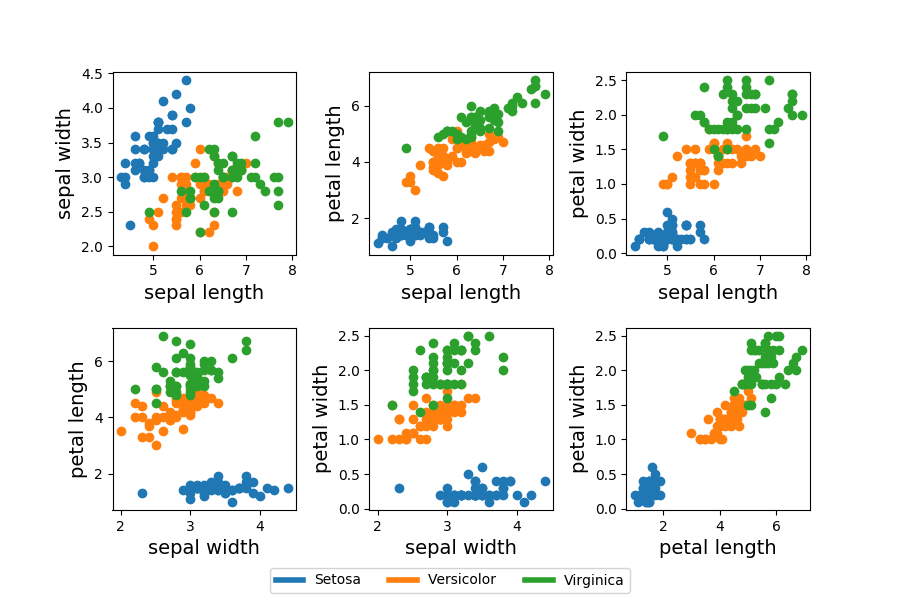

In [8]:
# format axes labels
var_arr = [i.rstrip(' (cm)') for i in iris_pd.columns[:4]]
# create legend
from matplotlib.lines import Line2D
labels = ['Setosa', 'Versicolor', 'Virginica']
legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='Setosa'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Versicolor'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Virginica'),]
# create figure; the numbers here are hard-coded based on the size of the data set
fig = plt.figure(figsize=(9,6))
cnt = 1
for a in range(4):
    for b in range(a+1,4):
        ax = fig.add_subplot(2, 3, cnt)
        for i in range(3):
            # note the use of pandas to aid in the slicing of data
            tmp_data = iris_pd[iris_pd['target'] == i]
            x_sub = tmp_data.drop(columns='target')
            x_sub = x_sub.get_values()
            # you may also use ax.scatter; linestyle, marker args may change
            ax.plot(x_sub[:,a], x_sub[:,b], linestyle='', marker='o')
            ax.set_xlabel(r"{}".format(var_arr[a]), fontsize=14)
            ax.set_ylabel(r"{}".format(var_arr[b]), fontsize=14)
        cnt += 1
# adjust plot spacing
plt.subplots_adjust(bottom=0.15, wspace=0.4, hspace=0.4)
# add legend
plt.figlegend(handles=legend_elements, labels=labels, loc='lower center',
              ncol=3, bbox_to_anchor=(0.5, 0.0))

plt.show()

## Analysis <a class="anchor" id="analysis"></a>

### Observations

- Setosa should be trivially easy to separate from the others (petal length alone would suffice)
- Versicolor and Virginica are clearly different, but show overlap in all of these projections

### Summary

While it would be trivial to separate Setosa from Versicolor and Virginica, we will not do so at this time (this strategry may be important in more complicated examples). If we were to pre-screen Setosa, we could perform a simple separation on each of the remaining combinations of variables and combine via weighting to create an effective classifier (this will be left as an exercise to the reader).

Instead, we will first investigate **Dimensionality Reduction** techniques before implementing other ML methods to predict/classify data

# Dimensionality Reduction <a class="anchor" id="dimensionality-reduction"></a>

During our [Data Exploration](#exploration) step, we effectively reduced the dimensionality of the data $4 \to 2$ by throwing out two of the dimensions. We can take all the variables into account while reducing the dimensions using PCA or t-SNE:

## PCA <a class="anchor" id="pca"></a>

We'll start with PCA

References:

- [Visual Explanation](http://setosa.io/ev/principal-component-analysis/)
- [In-depth theory explanation (may be overkill)](https://medium.com/@aptrishu/understanding-principle-component-analysis-e32be0253ef0)

<IPython.core.display.Javascript object>


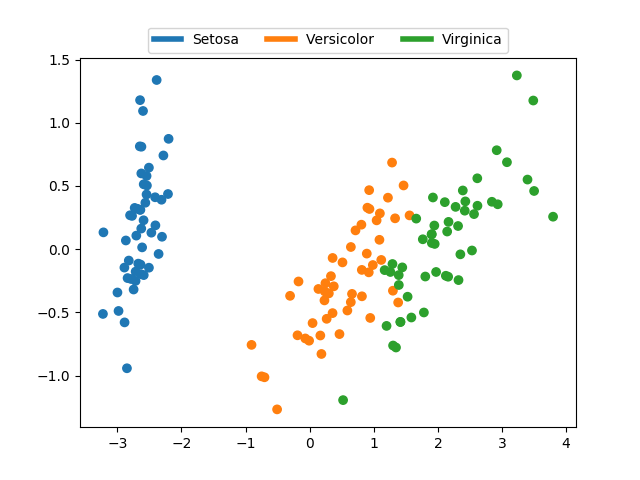

In [9]:
# take iris data and extract into inputs (X) and outputs (y)
X = iris.data
y = iris.target

# take the input X data and reduce to 2 dimensions via PCA
model = PCA(n_components=2)
model.fit(X)
X_reduced = model.transform(X)
# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap='tab10', vmax=10)
labels = ['Setosa', 'Versicolor', 'Virginica']
legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='Setosa'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Versicolor'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Virginica'),]
ax.legend(handles=legend_elements, labels=labels, loc='upper center',
              ncol=3, bbox_to_anchor=(0.5, 1.1))
plt.show()

Here we are viewing the eigenvectors of the principle components. This is definitely an improvement upon the sweep of variable combinations previously, we may be able to do better in 3 dimensions:

<IPython.core.display.Javascript object>


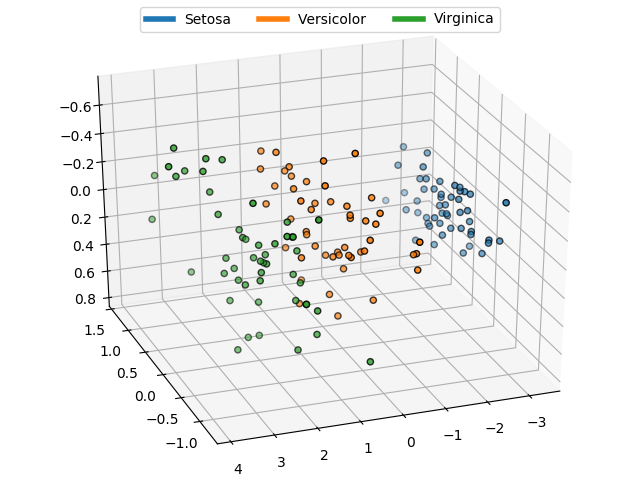

In [10]:
X_reduced = PCA(n_components=3).fit_transform(X)
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2],
           c=y, edgecolor='k', cmap='tab10', vmax=10)
labels = ['Setosa', 'Versicolor', 'Virginica']
legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='Setosa'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Versicolor'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Virginica'),]
ax.legend(handles=legend_elements, labels=labels, loc='upper center',
              ncol=3)
plt.show()

### Summary

PCA does improve upon combinations of two variables to separate the three types of irises. We will now compare against the t-SNE

## t-SNE <a class="anchor" id="tsne"></a>

Now, for t-SNE, or the *t-Stochastic Neighbor Embedding*. Like PCA, this reduces the dimensionality of data. An explanation of t-SNE is beyond the scope of this notebook, so please refer to the following links:

References:

- [Laurens van der Maaten](https://lvdmaaten.github.io/tsne/)
  - [Original paper](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
- [Interactive explanation](https://distill.pub/2016/misread-tsne/)
- [PCA vs. tSNE](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)
- [Additional walkthrough](https://www.datacamp.com/community/tutorials/introduction-t-sne)

In [11]:
model = TSNE(random_state=58, verbose=0, n_components=2, early_exaggeration=15,
             learning_rate=30, perplexity=50, n_iter=2000)
X_reduced = model.fit_transform(X)

<IPython.core.display.Javascript object>


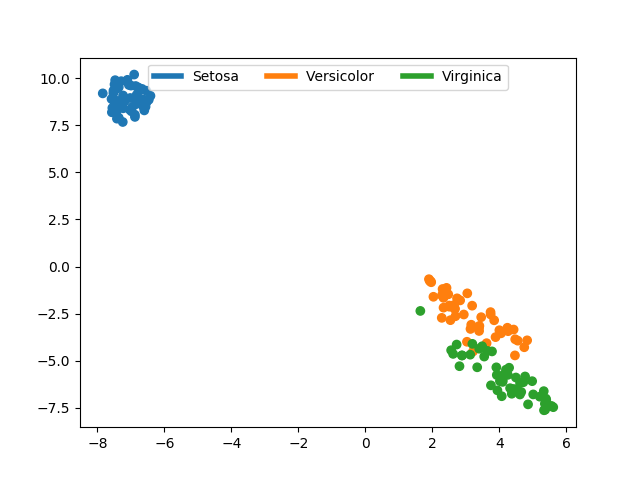

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap='tab10', vmax=10)
labels = ['Setosa', 'Versicolor', 'Virginica']
legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='Setosa'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Versicolor'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Virginica'),]
ax.legend(handles=legend_elements, labels=labels, loc='upper center',
              ncol=3)
plt.show()

t-SNE in 2D performs similarly, perhaps a bit better than PCA, in 2D. What about 3D

In [13]:
model = TSNE(random_state=42, verbose=0, n_components=3, early_exaggeration=20,
             learning_rate=50, perplexity=50, n_iter=5000)
X_reduced = model.fit_transform(X)

<IPython.core.display.Javascript object>


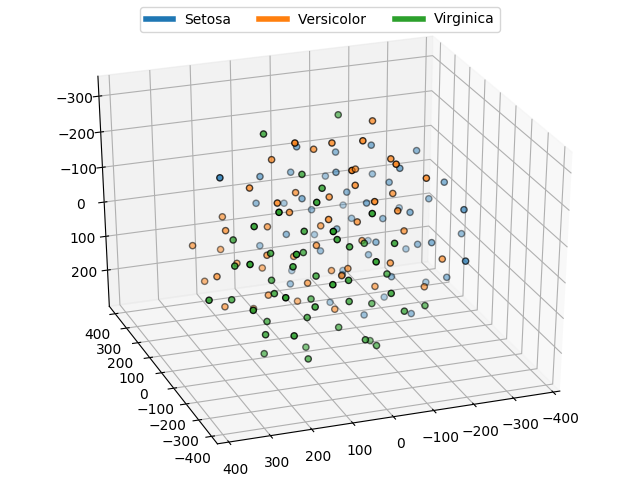

In [14]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2],
           c=y, edgecolor='k', cmap='tab10', vmax=10)
labels = ['Setosa', 'Versicolor', 'Virginica']
legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='Setosa'),
                   Line2D([0], [0], color='tab:orange', lw=4, label='Versicolor'),
                   Line2D([0], [0], color='tab:green', lw=4, label='Virginica'),]
ax.legend(handles=legend_elements, labels=labels, loc='upper center',
              ncol=3)
plt.show()

### Observations

- PCA and t-SNE can reduce the dimensionality of the data $\left( 4 \to 2 \right)$ while separating the data (in this way effectively **clustering** or **classifying** the data)
- 2D PCA, 3D PCA, and 2D t-SNE are effectively equal at reducing and separating the data

### Applicability in Classification

The PCA method "learns" the projection of the training data's dimenionality to the reduced dimensionality. This projection may then be applied to new data, effectively enabling this dimensionality reducition technique to be applied in a pipeline. This is not the case for t-SNE: t-SNE requires all data to be reduced to be present at time of fitting. This makes t-SNE inappropriate for our data.

### Summary

PCA and t-SNE are more effective at reducing dimensionality and separating data than simply sweeping possible combindations of variables. PCA is able to learn its projection and apply it to new data, making it suitable for use in a pipeline (as we will see later)

# Machine Learning Methods for "Classification" <a class="anchor" id="classification"></a>

*Note: while some of these are technically found in other regions of the cheat sheet, we are using them to classify. This is an important lesson*

Let's start by splitting the data into training and testing data (Note that there are $150$ data points, so we'll use 80% to train, and validate on 20%)

In [15]:
np.random.seed(42)
idxs = np.random.permutation(X.shape[0])
X_train = X[idxs[:120]]
X_test = X[idxs[120:]]
y_train = y[idxs[:120]]
y_test = y[idxs[120:]]

## Support Vector Classifier <a class="anchor" id="svc"></a>

Let's start with a perennial favorite, the Support Vector Classifier. We will be *increasing* the dimensionality of the data, allowing us to draw dividing hyperplanes between different data points. We will be using the default *radial kernel*, effectively allowing the "lines" that divide classes to be curved.

References:

- [SVM Theory](https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72)
- [Understanding SVM](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

<IPython.core.display.Javascript object>


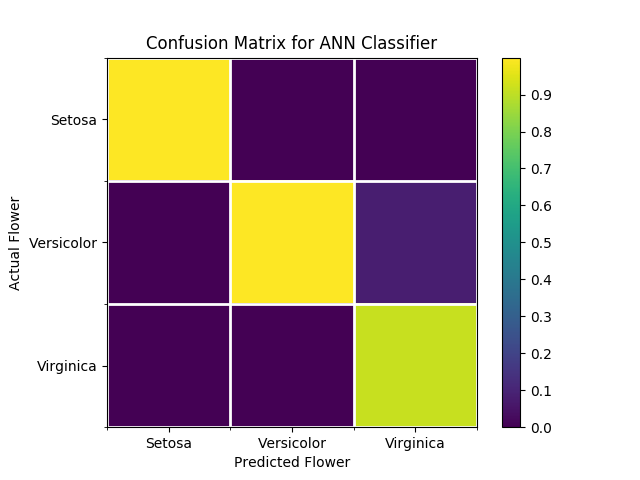

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.25, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

   micro avg       0.97      0.97      0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion matrix:
[[ 7  0  0]
 [ 0 11  0]
 [ 0  1 11]]


In [16]:
# Create a classifier: a support vector classifier
model = svm.SVC(gamma=0.25)

# fit the data
model.fit(X_train, y_train)

# get the prediction, performance in a confusion matrix
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
ax.set_xticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_yticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Flower")
ax.set_ylabel("Actual Flower")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

## Gaussian Mixture Model <a class="anchor" id="gmm"></a>

Now we will look at a Gaussian Mixture Model. This fits a mixture of Gaussian functions to our data in higher-dimensional space. This allows us to predict the class of our data given new data.

References:

- [Overview](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html)

(30,)


<IPython.core.display.Javascript object>


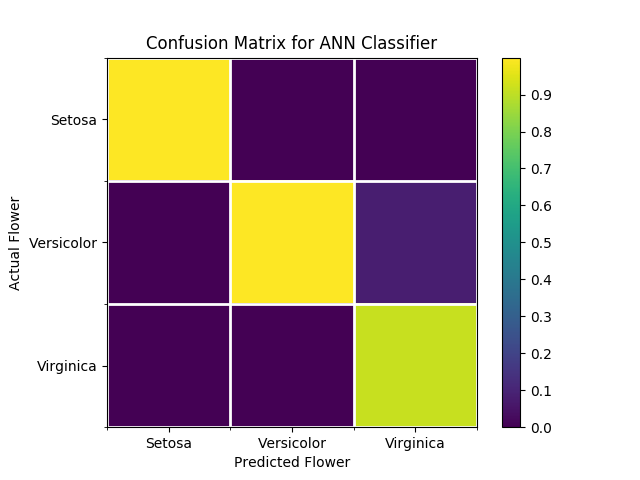

Classification report for classifier GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=array([[4.98605, 3.43488, 1.46744, 0.24884],
       [5.92051, 2.77179, 4.2641 , 1.33846],
       [6.60789, 2.97632, 5.55   , 2.04737]]),
        n_components=3, n_init=1, precisions_init=None, random_state=None,
        reg_covar=1e-06, tol=0.001, verbose=0, verbose_interval=10,
        warm_start=False, weights_init=None):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

   micro avg       0.97      0.97      0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion matrix:
[[ 7  0  0]
 [ 0 11  0]
 [ 0  1 11]]


In [17]:
# we train on 3 classes
# feel free to change the covariance type and see how performance changes
model = GaussianMixture(n_components=3, covariance_type='tied')
# init
model.means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(3)])
model.fit(X_train)
y_pred = model.predict(X_test)
print(y_pred.shape)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
ax.set_xticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_yticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Flower")
ax.set_ylabel("Actual Flower")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

## Artificial Neural Networks <a class="anchor" id="ann"></a>

What example would be complete without a neural net?

References:

- [Example](https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/)

In [18]:
model = Sequential()
model.add(Dense(8, activation='sigmoid', input_dim=4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, np_utils.to_categorical(y_train), batch_size=8, epochs=200)

Epoch 1/200
120/120 [==============================] - 1s 8ms/step - loss: 1.2057 - acc: 0.0000e+00
Epoch 2/200
120/120 [==============================] - 0s 376us/step - loss: 1.1690 - acc: 0.0000e+00
Epoch 3/200
120/120 [==============================] - 0s 307us/step - loss: 1.1375 - acc: 0.0000e+00
Epoch 4/200
120/120 [==============================] - 0s 335us/step - loss: 1.1166 - acc: 0.0083
Epoch 5/200
120/120 [==============================] - 0s 328us/step - loss: 1.1000 - acc: 0.0250
Epoch 6/200
120/120 [==============================] - 0s 346us/step - loss: 1.0861 - acc: 0.1583
Epoch 7/200
120/120 [==============================] - ETA: 0s - loss: 1.1130 - acc: 0.250 - 0s 327us/step - loss: 1.0735 - acc: 0.3750
Epoch 8/200
120/120 [==============================] - 0s 291us/step - loss: 1.0626 - acc: 0.5250
Epoch 9/200
120/120 [==============================] - 0s 310us/step - loss: 1.0514 - acc: 0.5917
Epoch 10/200
120/120 [==============================] - 0s 304us/step 

120/120 [==============================] - 0s 260us/step - loss: 0.4429 - acc: 0.9583
Epoch 84/200
120/120 [==============================] - 0s 261us/step - loss: 0.4400 - acc: 0.9583
Epoch 85/200
120/120 [==============================] - 0s 266us/step - loss: 0.4366 - acc: 0.9583
Epoch 86/200
120/120 [==============================] - 0s 277us/step - loss: 0.4341 - acc: 0.9583
Epoch 87/200
120/120 [==============================] - 0s 273us/step - loss: 0.4309 - acc: 0.9667
Epoch 88/200
120/120 [==============================] - 0s 275us/step - loss: 0.4272 - acc: 0.9750
Epoch 89/200
120/120 [==============================] - 0s 272us/step - loss: 0.4245 - acc: 0.9583
Epoch 90/200
120/120 [==============================] - 0s 270us/step - loss: 0.4221 - acc: 0.9583
Epoch 91/200
120/120 [==============================] - 0s 274us/step - loss: 0.4183 - acc: 0.9583
Epoch 92/200
120/120 [==============================] - 0s 278us/step - loss: 0.4154 - acc: 0.9583
Epoch 93/200
120/120 [=

120/120 [==============================] - 0s 299us/step - loss: 0.2721 - acc: 0.9833
Epoch 165/200
120/120 [==============================] - 0s 273us/step - loss: 0.2707 - acc: 0.9750
Epoch 166/200
120/120 [==============================] - 0s 259us/step - loss: 0.2684 - acc: 0.9750
Epoch 167/200
120/120 [==============================] - 0s 269us/step - loss: 0.2672 - acc: 0.9833
Epoch 168/200
120/120 [==============================] - ETA: 0s - loss: 0.2506 - acc: 1.000 - 0s 268us/step - loss: 0.2657 - acc: 0.9833
Epoch 169/200
120/120 [==============================] - 0s 257us/step - loss: 0.2644 - acc: 0.9750
Epoch 170/200
120/120 [==============================] - 0s 274us/step - loss: 0.2631 - acc: 0.9750
Epoch 171/200
120/120 [==============================] - 0s 262us/step - loss: 0.2618 - acc: 0.9750
Epoch 172/200
120/120 [==============================] - 0s 258us/step - loss: 0.2602 - acc: 0.9833
Epoch 173/200
120/120 [==============================] - 0s 261us/step - los

<IPython.core.display.Javascript object>


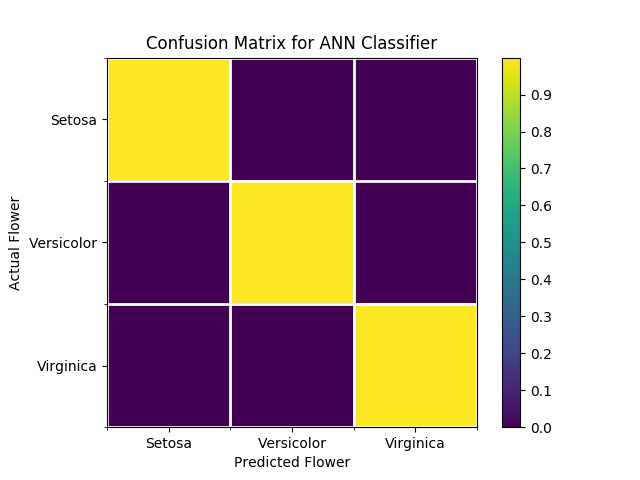

30/30 [==============================] - 0s 902us/step
loss = 0.23512382805347443, accuracy=1.0
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f9fcf069a58>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

   micro avg       1.00      1.00      1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion matrix:
[[ 7  0  0]
 [ 0 11  0]
 [ 0  0 12]]


In [20]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
ax.set_xticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_yticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Flower")
ax.set_ylabel("Actual Flower")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()
score = model.evaluate(X_test, np_utils.to_categorical(y_test))
print(f"loss = {score[0]}, accuracy={score[1]}")
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test, y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred.argmax(axis=1)))

## Summary <a class="anchor" id="classification-summary"></a>

| Method | Score |
|:-------|------:|
|  SVM   | 0.97 |
|  GMM   | 0.97 |
|  ANN   | 1.00 | 

**Note: SVM and GMM were only incorrect in 1/30 predictions**

# Pipelines <a class="anchor" id="pipe"></a>

Scikit-learn also provides mechanisms for creating a pipeline of analysis. In these examples, we will start by using PCA to reduce the dimensionality, then followed by SVC or GMM

## GMM <a class="anchor" id="pipe-gmm"></a>

<IPython.core.display.Javascript object>


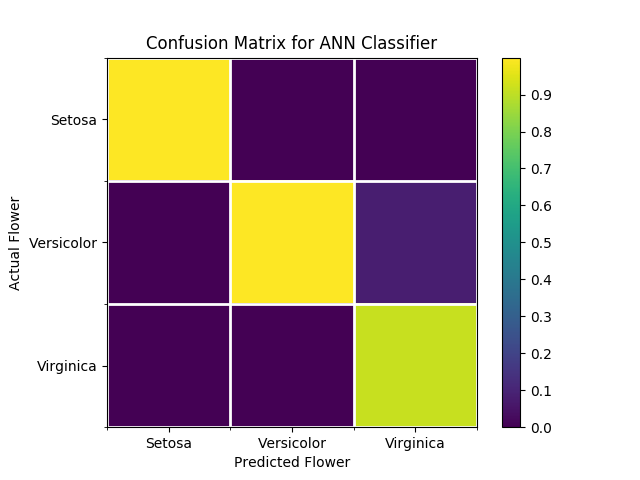

Classification report for classifier Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('gmm', GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None))]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

   micro avg       0.97      0.97      0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion matrix:
[[ 7  0  0]
 [ 0 11  0]
 [ 0  1 11]]


In [21]:
pca = PCA(n_components=2)
gmm = GaussianMixture(n_components=3, covariance_type='tied', init_params='kmeans')
steps = [('pca', pca), ('gmm', gmm)]
pipe = Pipeline(steps)
pipe.fit(X_train)

y_pred = pipe.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
ax.set_xticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_yticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Flower")
ax.set_ylabel("Actual Flower")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (pipe, metrics.classification_report(y_test, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

## SVC <a class="anchor" id="pipe-svc"></a>

(120, 4)


<IPython.core.display.Javascript object>


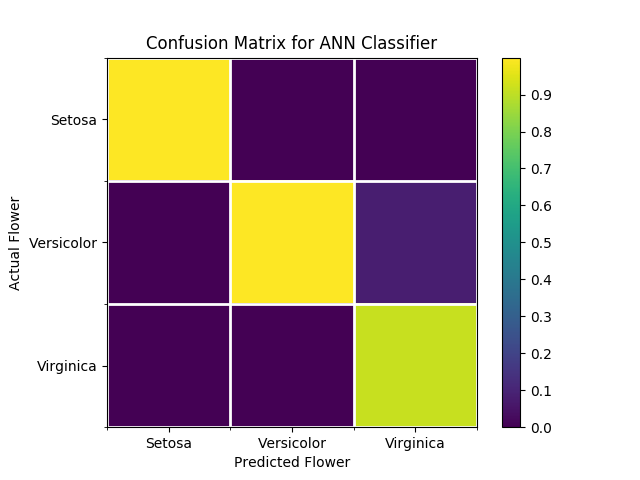

Classification report for classifier Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.25, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.92      1.00      0.96        11
           2       1.00      0.92      0.96        12

   micro avg       0.97      0.97      0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


Confusion matrix:
[[ 7  0  0]
 [ 0 11  0]
 [ 0  1 11]]


In [22]:
pca = PCA(n_components=2)
svc = svm.SVC(gamma=0.25, kernel='rbf')
steps = [('pca', pca), ('svc', svc)]
pipe = Pipeline(steps)
print(X_train.shape)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 3, 1))
ax.set_yticks(np.arange(0, 3, 1))
ax.set_xticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_yticklabels(['Setosa', 'Versicolor', 'Virginica'])
ax.set_xticks(np.arange(-0.5, 3, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Flower")
ax.set_ylabel("Actual Flower")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (pipe, metrics.classification_report(y_test, y_pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

## Summary

In these examples, chaining PCA with SVC and GMM did not improve performance. This may/will change depending on your problem and your data